# Electronics Product Recommender
> Training electronics product recommender on Amazon electronics product rating data using turicreate and surprise library based popularity and collaborative filtering models and evaluating on RMSE

- toc: true
- badges: true
- comments: true
- categories: [Turicreate, Surprise, HyperTuning, Electronics, Retail, ECommerce]
- image:

### Install libraries

In [2]:
#hide-output
!pip install surprise
!pip install turicreate

     |████████████████████████████████| 11.8 MB 4.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617790 sha256=e23d50c691ab2d0bf5de01caab6e96fae23ced0fc2a55e3e4a52057852b1c06d
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise
     |████████████████████████████████| 92.0 MB 13 kB/s 
     |████████████████████████████████| 3.5 MB 33.9 MB/s 
     |████████████████████████████████| 86.4 MB 19 kB/s 
     |████████████████████████████████| 3.6 MB 41.3 MB/s 
     |████████████████████████████████| 322 kB 71.8 MB/s 
     |████████████████████████████████| 18.3 MB 1.1 MB/s 
     |████████████████████████████████| 449 kB 48.0 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 3.8 MB 22.5 MB/s 
     |████████████████████████████████| 2.9 MB 23.8 MB/s 
     |████████████████████████████████| 20.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import math
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

from surprise import Dataset
from surprise import Reader
from surprise import accuracy                                              
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

import turicreate

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

### Load the data
We will download the data from Kaggle, unzip it, and load it into pandas dataframe.

In [1]:
#hide-output
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pritech/ratings-electronics
!unzip ratings-electronics.zip

     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=9f64fd3042490f5a869a074ab4bf50ece0d0bb6ac513779d938b0fed70c4cfc0
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 96% 105M/109M [00:00<00:00, 96.7MB/s]
100% 109M/109M [00:00<00:00, 123MB/s] 


In [2]:
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df = pd.read_csv('ratings_Electronics.csv', names=columns)
electronics_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


### Pre-processing

In [3]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [4]:
electronics_df.isnull().sum()

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

In [5]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [36]:
print("Electronic Data Summary")
print("="*100)
print("\nTotal # of Ratings :",electronics_df.shape[0])
print("Total # of Users   :", len(np.unique(electronics_df.userId)))
print("Total # of Products  :", len(np.unique(electronics_df.productId)))
print("\n")
print("="*100)

Electronic Data Summary

Total # of Ratings : 7824482
Total # of Users   : 4201696
Total # of Products  : 476002




> Note: Number of products is less than number of users, so item-item colaborative filtering would make sense instead of user-user colaborative filtering.

### Sampling

There are more than 4.2 million users. It is big for a prototype version like ours. So we will select ~10K users randomly, and assume that the sample would represent the population.

In [6]:
userids_random10k = np.random.choice(electronics_df.userId.unique(), int(1e4))
electronics_df = electronics_df.loc[electronics_df.userId.isin(userids_random10k)]
electronics_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userId,18938,9985,A3V7D0LH8L7BG0,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
productId,18938,13606,B00DR0PDNE,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratings,18938,NaN,NaN,NaN,4.00385,1.38826,1,3,5,5,5


In [45]:
electronics_df.head()

,userId,productId,ratings
34,A3C5SMBSKKWNPT,0528881469,5.0
1018,A2OT9JAC4HOSEG,0972683275,5.0
1158,AMAR6CIOZUQO4,0972683275,4.0
1383,A2LK476A1UDRDK,1400501466,5.0
1530,A2RWGZD24R9JK0,1400501466,2.0


### Encoding

Label encode userid and productid and int for ratings.

In [7]:
le_userid = LabelEncoder()
electronics_df.userId = le_userid.fit_transform(electronics_df.userId)

le_prodid = LabelEncoder()
electronics_df.productId = le_prodid.fit_transform(electronics_df.productId)

electronics_df.ratings = electronics_df.ratings.astype('int32')

In [47]:
electronics_df.head()

,userId,productId,ratings
34,6143,0,5.0
1018,4404,1,5.0
1158,8957,1,4.0
1383,4170,2,5.0
1530,4623,2,2.0


### Matrix
Constructing pivot table on `userId` and `productId` column based on the value of `ratings`


In [48]:
final_ratings_matrix = electronics_df.pivot(index = 'userId', columns ='productId', values = 'ratings')
final_ratings_matrix.head()

productId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,13573,13574,13575,13576,13577,13578,13579,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589,13590,13591,13592,13593,13594,13595,13596,13597,13598,13599,13600,13601,13602,13603,13604,13605,13606,13607,13608,13609,13610,13611,13612
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
#Calucating the density of the rating marix
given_num_of_ratings = final_ratings_matrix.count().sum()
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  18735
possible_num_of_ratings =  135993870
density: 0.01%


### Split

In [65]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df, test_size = 0.3, random_state=42)
train_data.head()

,userId,productId,ratings
7229348,6439,12502,1
1373091,4247,2558,5
5188285,4693,9093,5
4702171,5568,8288,1
249210,8568,459,5


In [66]:
print('Shape of training data: ', train_data.shape)
print('Shape of testing data: ', test_data.shape)

Shape of training data:  (13114, 3)
Shape of testing data:  (5621, 3)


## Models

### Popularity (manual)

In [67]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)

#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5)
popularity_recommendations

,productId,score,rank
7255,9751,29,1.0
9574,12872,27,2.0
4418,5911,26,3.0
4429,5925,23,4.0
2503,3324,21,5.0


In [68]:
# Sample fuction to use manual popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [69]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

      userId  productId  score  rank
7255      10       9751     29   1.0
9574      10      12872     27   2.0
4418      10       5911     26   3.0
4429      10       5925     23   4.0
2503      10       3324     21   5.0


The list of recommendations for the userId: 100

      userId  productId  score  rank
7255     100       9751     29   1.0
9574     100      12872     27   2.0
4418     100       5911     26   3.0
4429     100       5925     23   4.0
2503     100       3324     21   5.0


The list of recommendations for the userId: 150

      userId  productId  score  rank
7255     150       9751     29   1.0
9574     150      12872     27   2.0
4418     150       5911     26   3.0
4429     150       5925     23   4.0
2503     150       3324     21   5.0




Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

In [70]:
#Calculating the RMSE of the popularity based recommendation system
#Rating present in the test data is the actual rating (Act_rating)
test_data2 = test_data.copy()
test_data2.drop(['userId'],axis=1,inplace=True)
test_data2.rename(columns = {'ratings':'Act_rating'}, inplace = True)

#Count of user_id for each unique product as recommendation score

train_data_grouped2 = train_data.groupby('productId').agg({'ratings': 'sum'}).reset_index()
train_data_grouped2.rename(columns = {'ratings': 'Sum_rating'},inplace=True)
train_data_grouped2.head()

,productId,Sum_rating
0,1,9
1,2,2
2,4,4
3,5,5
4,6,10


In [71]:
train_data_inner = pd.merge(train_data_grouped2, train_data_sort)
train_data_inner.head()

,productId,Sum_rating,score,rank
0,1,9,2,554.0
1,2,2,1,1560.0
2,4,4,1,1561.0
3,5,5,1,1562.0
4,6,10,2,555.0


In [72]:
#Obtain the average rating of the product across users
train_data_inner["Avg_Rating"] = train_data_inner["Sum_rating"]/train_data_inner["score"]
train_data_inner.head()

,productId,Sum_rating,score,rank,Avg_Rating
0,1,9,2,554.0,4.5
1,2,2,1,1560.0,2.0
2,4,4,1,1561.0,4.0
3,5,5,1,1562.0,5.0
4,6,10,2,555.0,5.0


In [73]:
#Merge the train data having average rating with the test data having actual rating at product level
test_data_inner = pd.merge(train_data_inner, test_data2)
test_data_inner.head()

,productId,Sum_rating,score,rank,Avg_Rating,Act_rating
0,2,2,1,1560.0,2.00,5
1,5,5,1,1562.0,5.00,1
2,36,17,4,158.0,4.25,4
3,36,17,4,158.0,4.25,3
4,44,8,2,559.0,4.00,5


In [74]:
#RMSE for popularity based recommender system
mse = mean_squared_error(test_data_inner["Act_rating"], test_data_inner["Avg_Rating"])
rmse = math.sqrt(mse)
print("RMSE for popularity based recommendation system:", rmse)

RMSE for popularity based recommendation system: 1.5949064890356024


### Popularity (turicreate)

In [76]:
train_data2 = turicreate.SFrame(train_data)
test_data2 = turicreate.SFrame(test_data)

In [77]:
popularity_model = turicreate.popularity_recommender.create(train_data2, user_id='userId', item_id='productId', target='ratings')

Preparing data set.

Data has 13114 observations with 7792 users and 10128 items.

Data prepared in: 0.035442s

13114 observations to process; with 10128 unique items.

In [79]:
random_5users = np.random.choice(userids_random10k, 5)
random_5users

array(['AAUVK4AE89NYN', 'A25BDRXNL57DSW', 'A2SZ0P5ND7C5AU',
       'A3MG1LEMIEK6L6', 'A3GS6AVYWXDV1I'], dtype=object)

In [83]:
#Recommend for a given set of users, since there are top 5 recommendation for 5 users, total rows will be 25
popularity_recomm = popularity_model.recommend(users=le_userid.transform(random_5users),k=5)
popularity_recomm.print_rows(num_rows=25)

+--------+-----------+-------+------+
| userId | productId | score | rank |
+--------+-----------+-------+------+
|  8118  |    7813   |  5.0  |  1   |
|  8118  |   10264   |  5.0  |  2   |
|  8118  |     11    |  5.0  |  3   |
|  8118  |    459    |  5.0  |  4   |
|  8118  |    2558   |  5.0  |  5   |
|  2989  |    7813   |  5.0  |  1   |
|  2989  |   10264   |  5.0  |  2   |
|  2989  |     11    |  5.0  |  3   |
|  2989  |    459    |  5.0  |  4   |
|  2989  |    2558   |  5.0  |  5   |
|  4696  |    7813   |  5.0  |  1   |
|  4696  |   10264   |  5.0  |  2   |
|  4696  |     11    |  5.0  |  3   |
|  4696  |    459    |  5.0  |  4   |
|  4696  |    2558   |  5.0  |  5   |
|  6905  |    7813   |  5.0  |  1   |
|  6905  |   10264   |  5.0  |  2   |
|  6905  |     11    |  5.0  |  3   |
|  6905  |    459    |  5.0  |  4   |
|  6905  |    2558   |  5.0  |  5   |
|  6477  |    7813   |  5.0  |  1   |
|  6477  |   10264   |  5.0  |  2   |
|  6477  |     11    |  5.0  |  3   |
|  6477  |  

In [84]:
pop_rmse = popularity_model.evaluate_rmse(test_data2,'ratings')
print(pop_rmse)
#The RMSE value for the popularity based model
pop_rmse["rmse_overall"]

{'rmse_by_user': Columns:
	userId	int
	rmse	float
	count	int

Rows: 4062

Data:
+--------+--------------------+-------+
| userId |        rmse        | count |
+--------+--------------------+-------+
|  7899  | 0.9914595089217633 |   1   |
|  2035  |        1.0         |   1   |
|  4631  | 0.7826086956521738 |   1   |
|  7148  |        0.0         |   1   |
|  1611  |        2.0         |   1   |
|  9056  | 0.809523299162902  |   3   |
|  8455  | 0.9144488141425273 |   6   |
|  9335  | 2.267623745719382  |   2   |
|  9784  |        0.25        |   1   |
|  2057  | 0.9914595089217633 |   1   |
+--------+--------------------+-------+
[4062 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns., 'rmse_by_item': Columns:
	productId	int
	rmse	float
	count	int

Rows: 4784

Data:
+-----------+----------------------+-------+
| productId |         rmse         | count |
+-----------+----------------------

1.4680131132616503

### Item-item similarity (turicreate)

This model first computes the similarity between items using the observations of users who have interacted with both items. Given a similarity between item i and j, S(i,j), it scores an item j for user u using a weighted average of the user’s previous observations Iu.


In [85]:
#Training the model for item-item similarity recommender
item_sim_model = turicreate.item_similarity_recommender.create(train_data2, user_id='userId',
                                                               item_id='productId', target='ratings',
                                                               similarity_type='cosine')

Preparing data set.

Data has 13114 observations with 7792 users and 10128 items.

Data prepared in: 0.040847s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 4.535ms                        | 12.75      |

| 6.68ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 767.178ms                           | 0                | 0               |

| 1.68s                               | 100              | 10128           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.70077s

In [86]:
#Get the item-item recommender RMSE value
item_rmse = item_sim_model.evaluate_rmse(test_data2,'ratings')
item_rmse["rmse_overall"]

4.251383811071518

### Matrix factorization (turicreate)

In [87]:
#Build a matrix based factorization model recommender system
factorization_model = turicreate.factorization_recommender.create(train_data2, user_id='userId',
                                                                  item_id='productId', target='ratings')

Preparing data set.

Data has 13114 observations with 7792 users and 10128 items.

Data prepared in: 0.032147s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 13114 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | No Decrease (9.31482 >= 1.90778)         |

| 3       | 0.390625          | 0.0447513                                |

| 4       | 0.195312          | 0.102946                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.390625          | 0.0447513                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 121us        | 1.89896           | 1.37803               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 25.868ms     | 2.04539           | 1.43014               | 0.390625    |

| 2       | 48.839ms     | 0.646759          | 0.804191              | 0.232267    |

| 3       | 65.837ms     | 0.223924          | 0.473193              | 0.171364    |

| 4       | 88.323ms     | 0.127786          | 0.357466              | 0.116134    |

| 5       | 97.538ms     | 0.0959603         | 0.309772              | 0.098237    |

| 10      | 157.055ms    | 0.0481838         | 0.219504              | 0.0584121   |

| 50      | 694.113ms    | 0.00579229        | 0.0760759             | 0.0174693   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.00529726

Final training RMSE: 0.0727496

In [88]:
fcm_rmse2 = factorization_model.evaluate_rmse(test_data2,'ratings')
fcm_rmse2["rmse_overall"]

1.4396566055812465

### Multiple models (surprise library)

In [8]:
rts_gp = electronics_df.groupby(by=['ratings']).agg({'userId': 'count'}).reset_index()
rts_gp.columns = ['ratings', 'Count']

#Subsetting the data to keep products having at least x=1 ratings
prod_ge=electronics_df.groupby("productId").filter(lambda x:x['ratings'].count() >= 2)
#Subsetting the data to keep users who have given at least y=1 ratings
user_ge=electronics_df.groupby("userId").filter(lambda x:x['ratings'].count() >= 2)
user_ge.drop(['ratings'],inplace=True,axis=1)
user_prod_ge = pd.merge(prod_ge,user_ge)
user_prod_ge.shape

(5004, 3)

> Tip: As we already sampled the data, so filtering by min. rating count of 2 here, but if you are not using sampling, feel free to raise this x,y bar to 5 or maybe 25.

In [9]:
# Set Rating Scale from 1 to 5
#We are running basic algorithms to check which one works best
reader = Reader(rating_scale=(1, 5))

# Load data with rating scale
#data = Dataset.load_from_df(new_df, reader)
data = Dataset.load_from_df(user_prod_ge,reader)

In [12]:
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=True)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=True)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=True)
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=True)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=True)
nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=True)
slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=5, verbose=True)
coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2445  1.3450  1.2181  1.2793  1.2899  1.2753  0.0431  
MAE (testset)     0.9743  1.0447  0.9636  1.0100  1.0035  0.9992  0.0286  
Fit time          0.18    0.18    0.20    0.18    0.12    0.17    0.02    
Test time         0.02    0.02    0.02    0.02    0.01    0.02    0.00    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4178  1.4257  1.3291  1.3990  1.3123  1.3768  0.0469  
MAE (testset)     1.0116  1.0009  0.9381  1.0074  0.9205  0.9757  0.0384  
Fit time          0.24    0.25    0.21    0.22    0.13    0.21    0.04    
Test time         0.02    0.03    0.02    0.02    0.01    0.02    0.01    
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean  

In [13]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))
print()

Algorithm	 RMSE		 MAE

KNN Basic 	 1.2753 	 0.9992
KNN Means 	 1.3768 	 0.9757
KNN ZScore 	 1.3681 	 0.9711

SVD 		 1.2486 	 0.9713
SVDpp 		 1.242 	 0.9605
NMF 		 1.5386 	 1.23

SlopeOne 	 1.3749 	 0.9775
CoClustering 	 1.4423 	 1.0326



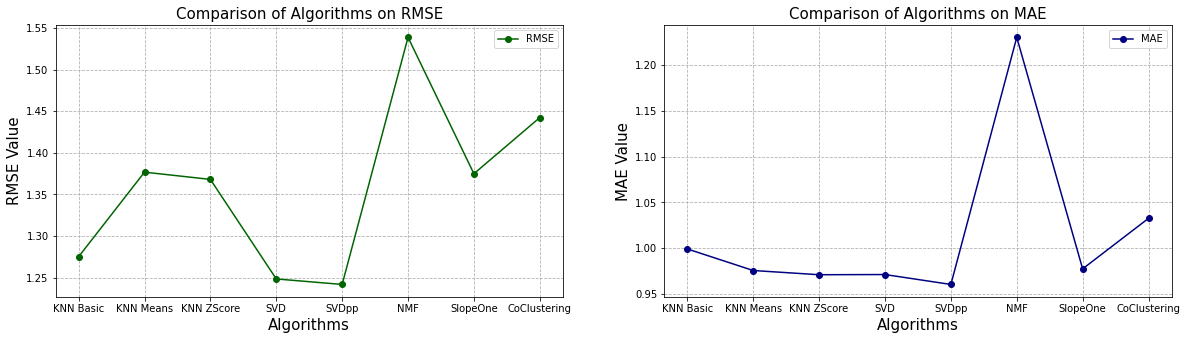

In [14]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

## Hyperparameter tuning
Grid Searching on SVD and SVDPP algorithms

In [15]:
raw_ratings = data.raw_ratings                         
# 90% trainset, 10% testset                                                
threshold = int(.9 * len(raw_ratings))                                     
trainset_raw_ratings = raw_ratings[:threshold]                             
test_raw_ratings = raw_ratings[threshold:]             
data.raw_ratings = trainset_raw_ratings        

In [16]:
# Parameter space
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs.fit(data)
algo_svdpp = svdpp_gs.best_estimator['rmse']   

# retrain on the whole train set                      
trainset = data.build_full_trainset()                 
algo_svdpp.fit(trainset)

# now test on the trainset                                                 
testset = data.construct_testset(trainset_raw_ratings)                     
predictions_train = algo_svdpp.test(testset)                                           
print('Accuracy on the trainset:')                                         
accuracy.rmse(predictions_train)                                                 

# now test on the testset                                                  
testset = data.construct_testset(test_raw_ratings)                         
pred_svdpp=algo_svdpp.test(testset)
print('Accuracy on the testset:')                                          
accuracy.rmse(pred_svdpp)  


svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svd_gs.fit(data)
algo_svd = svd_gs.best_estimator['rmse']    
# retrain on the whole train set                      
trainset = data.build_full_trainset()                  
algo_svd.fit(trainset)
# now test on the trainset                                                 
testset = data.construct_testset(trainset_raw_ratings)                     
predictions_train = algo_svd.test(testset)                                           
print('Accuracy on the trainset:')                                         
accuracy.rmse(predictions_train)                                                 

# now test on the testset                                                  
testset = data.construct_testset(test_raw_ratings)                         
pred_svd=algo_svd.test(testset)
print('Accuracy on the testset:')                                          
accuracy.rmse(pred_svd) 

Accuracy on the trainset:
RMSE: 0.8932
Accuracy on the testset:
RMSE: 1.1711
Accuracy on the trainset:
RMSE: 0.7898
Accuracy on the testset:
RMSE: 1.1721


1.1720522705869012

In [17]:
print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

SVDpp - RMSE: 1.2523 ; MAE: 0.9687
SVD   - RMSE: 1.2556 ; MAE: 0.9724
RMSE = {'n_epochs': 20, 'lr_all': 0.009, 'reg_all': 0.6}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
RMSE = {'n_epochs': 25, 'lr_all': 0.007, 'reg_all': 0.6}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


In [24]:
def get_top_n_recommendations(reccomemndations, n=5):
    # First map the reccommendations to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in reccomemndations:
        inverselabel_iid = le_prodid.inverse_transform([iid])[0]
        inverselabel_uid = le_userid.inverse_transform([uid])[0]
        top_n[inverselabel_uid].append((inverselabel_iid, est))

    #sort predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [25]:
#collapse-output
top_5 = get_top_n_recommendations(pred_svd, n=5)
for uid, user_ratings in top_5.items():
    print(uid, [iid for (iid, _) in user_ratings])

A2T2NQ0XMM1NMS ['B00AANMVNQ']
A157WY31PWYF97 ['B00AB7QZMY']
ACDJ7VVN4C5L8 ['B00ACVI202']
A1I80FTQCLYOOP ['B00AEP8TG8']
A60WZCOIUL2E6 ['B00AGA6FLC', 'B00GQTQJZ4']
A3O5LIK26YLY5G ['B00AGA6FLC']
A1SMMP9QQRPNI9 ['B00AGA6FLC']
A5JHK0A5DEZXF ['B00AGABISW']
ALYIYCV6QZG11 ['B00AGABISW']
ASWX8ZPQTPHFR ['B00AGH81M6']
A1Y95ZNQLGF53R ['B00AGOSQI8']
A13II4ZI571PSB ['B00AHBKW2S']
A3DYLR5H37T5XQ ['B00AHBKW2S']
A3KJQIEAFJ9I5J ['B00AHBKW2S']
A2JJ4T65XOZ86M ['B00AHPSTJW']
A1ATTNW67B3IE2 ['B00AI3RRAA']
A1PUBCPEMWZV2S ['B00AI3RRAA']
A18SICYL1GJC11 ['B00AIQEU5C']
AA9CC2HCF2IA8 ['B00AIRUOI8', 'B00BFNJ2NW']
A1EUKXIQ3F0P2P ['B00AIRUOI8']
AI0OSZHLIXAN6 ['B00AJHDZSI']
A2X117IF5LX1B5 ['B00AJHDZSI']
A2J0QEOGHVHXTC ['B00AJHDZSI']
A3QR9801FLODXI ['B00AJHDZSI', 'B00B46XUQU']
A2U6ATA01EYIBK ['B00AJHDZSI', 'B00F0DD0I6']
A2WE3YFGKRAP3K ['B00AL950GO']
AXOFS9DDU0E0A ['B00ANDHBNS']
A29E3ENX3ALT1L ['B00ANDHBNS']
AMEX3N4SCZENF ['B00AO1XFM0']
A1WML7XCNIB968 ['B00AO1XFM0', 'B00CMQTVK0']
A2FUB31VF55UZ3 ['B00AO1XFM0']
A3DC5FJB5

**Observation :**
* The Popularity-based recommender system is a non-personalized recommender system and these are based on frequency counts, which may be not suitable to the user.
* Model-based Collaborative Filtering is a personalized recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.
* Item Similarity Based model performed worse than even simple popularity based models.
* Hyper parameter tuning with GridSearch improve model performance.